 # Contents<a id="0"></a>

- [1 Abstract](#1)
- [2 Modules](#2)
- [3 Load Data](#3)
  - [3.1 Pandas](#3.1)
  - [3.2 Datatable](#3.2)
  - [3.3 Statistics](#3.3)
  - [3.4 Resource optimization (In progress)](#3.4)
- [4 Preprocessing](#4)
  - [4.1 Missing values](#4.1)
  - [4.2 Standardization](#4.2)
- [5 Modeling](#5)
  - [5.1 LightGBM](#5.1)
  - [5.2 CatBoost](#5.1)
  - [5.3 XGBoost](#5.3)
- [6 Cross Validation (K-Fold)](#6)
  - [6.1 Numpy](#6.1)
  - [6.2 Scikit Learn](#6.2)
    - [6.2.1 train_test_split](#6.2.1)
    - [6.2.2 K-Fold](#6.2.2)
    - [6.2.3 StratifiedKFold](#6.2.3)
    - [6.2.4 ShuffleSplit](#6.2.4)
  - [6.3 Boosters with cross validation](#6.3)
- [7 Hyperparameter](#7)
  - [7.1 Optuna for LightGBM](#7.1)
  - [7.2 Optuna for CatBoost](#7.2)
  - [7.3 Optuna for XGBoost](#7.3)
- [8 Quality of predictions](#8)
- [9 Submission](#9)

 # 1 Abstract<a id="1"></a>

 These are my personal notes. I would like to share them with you and I hope it can be useful for you, even if it is a small help. I will try to update these notes over time.

 # 2 Modules<a id="2"></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import datatable as dt
import warnings
import gc

# Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

# Boosters
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Hyperparameter 
import optuna

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

DEMO=True

 # 3 Load Data<a id="3"></a>

 It seems that Pandas load data slowly. One alternative is to use `datatable` and convert theme to `Pandas`. [Link](https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro#Read-in-the-massive-dataset)

 <div class="alert alert-info">
   <svg xmlns="http://www.w3.org/2000/svg" width="32" height="32" fill="currentColor" class="bi bi-info-circle-fill" viewBox="0 0 16 16">
   <path d="M8 16A8 8 0 1 0 8 0a8 8 0 0 0 0 16zm.93-9.412-1 4.705c-.07.34.029.533.304.533.194 0 .487-.07.686-.246l-.088.416c-.287.346-.92.598-1.465.598-.703 0-1.002-.422-.808-1.319l.738-3.468c.064-.293.006-.399-.287-.47l-.451-.081.082-.381 2.29-.287zM8 5.5a1 1 0 1 1 0-2 1 1 0 0 1 0 2z"/>
 </svg>
 </svg>
 <b style="font-size: x-large;">MORE INFO</b><br>
    ___The difference between <code>Pandas</code> and <code>Datatable</code> and the best way to load data is fully <code><a href="https://www.kaggle.com/akmeghdad/tps-1021-how-to-make-better-use-of-kaggle-memory" target="_blank">explained here</a></code>
 </div>

 ## 3.1 Pandas<a id="3.1"></a>

In [ ]:
# The id column disrupts the training so delete it
train = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/train.csv').drop(columns=['id'])
test = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/test.csv', index_col=0) # another way to drop the column 
submission = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv')

 ## 3.2 Datatable<a id="3.2"></a>

 To learn more about Datatable [see this kaggle code](https://www.kaggle.com/sudalairajkumar/getting-started-with-python-datatable). Datatable `fread` documentation [is here](https://datatable.readthedocs.io/en/latest/api/dt/fread.html)

In [ ]:
del train
del test
del submission
gc.collect(); # To not output don't forget ";"

In [ ]:
train =dt.fread('/kaggle/input/tabular-playground-series-nov-2021/train.csv', columns=lambda cols:[col.name not in ('id') for col in cols]).to_pandas()
test = dt.fread('/kaggle/input/tabular-playground-series-nov-2021/test.csv', columns=lambda cols:[col.name not in ('id') for col in cols]).to_pandas()
submission = dt.fread('/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv').to_pandas()

 ## 3.3 Statistics<a id="3.3"></a>

 Display head of DataFrame is not normally legible. so we [transpose](https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.DataFrame.T.html) it.

In [ ]:
train.head().T

 We can't view all the columns and datatypes when we want print a concise summary of a DataFrame, we use `verbose` as argument to solve this problem

In [ ]:
train.info(verbose=True, memory_usage="deep")

 It semble [transpose](https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.DataFrame.T.html) is good idea to show any other methods of DataFrame.

In [ ]:
train.describe().T

In [ ]:
train.sample(4).T

 ## 3.4 Resource optimization (In progress) <a id="3.4"></a>

 # 4 Preprocessing

 ## 4.1 Missing values

 There is no Missing values in [Tabular Playground Series - Oct 2021 data](https://www.kaggle.com/c/tabular-playground-series-oct-2021/data)

In [ ]:
print(f'There is:\n{train.isna().sum().sum()} null values in train dataframe\n{test.isna().sum().sum()} null values in test dataframe')

 ## 4.2 Standardization<a id="4.2"></a>
 This section will not be useful if you want to use classification algorithms

 <div class="alert alert-danger">
 <svg xmlns="http://www.w3.org/2000/svg" width="32" height="32" viewBox="0 0 16 16" fill="currentColor">
   <path d="M8.982 1.566a1.13 1.13 0 0 0-1.96 0L.165 13.233c-.457.778.091 1.767.98 1.767h13.713c.889 0 1.438-.99.98-1.767L8.982 1.566zM8 5c.535 0 .954.462.9.995l-.35 3.507a.552.552 0 0 1-1.1 0L7.1 5.995A.905.905 0 0 1 8 5zm.002 6a1 1 0 1 1 0 2 1 1 0 0 1 0-2z"/>
 </svg>
 <b style="font-size: x-large;">ATTENTION</b><br>
     Standardization with <code>sklearn.preprocessing.*</code> may overflow memory.
 </div>

 The `StandardScaler` method uses the following formula

 ![StandardScaler](https://raw.githubusercontent.com/akmeghdad/data-science-note/master/src/images/StandardScaler-formula.jpg)

In [ ]:
# from sklearn.preprocessing import StandardScaler
if not DEMO:
    z = StandardScaler()

    # Separate (method 1)
    z.fit(train)
    train_z = z.transform(train)

    # Together (method 1)
    train_z = z.fit_transform(train)

 The `QuantileTransformer` method seems to be better. 
 
  - 🙏 <https://www.kaggle.com/melanie7744/tps9-how-to-transform-your-data>

In [ ]:
# from sklearn.preprocessing import QuantileTransformer
if not DEMO:
    qt = QuantileTransformer(output_distribution = 'normal')
    
    # Separate (method 1)
    qt.fit(train.iloc[:,:-1])
    train_qt = qt.transform(train.iloc[:,:-1])
    test_qt = qt.transform(test)

    # Together (method 2)
    train_qt = qt.fit_transform(train.iloc[:,:-1])
    test_qt = qt.transform(test)

 # 5 Modeling<a id="5"></a>

 LightGBM, CatBoost and XGBoost are known as new ways to build models. Parameter settings are very important in these three methods. Only the basic parameters are listed here.


 ## 5.1 LightGBM<a id='5.1'></a>
 Official documentations for parameters:
 - [https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
 - [https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst)

In [ ]:
# from lightgbm import LGBMClassifier
parameters = {
    'objective' : 'binary',
    'metric' : 'auc',
    'device' : 'gpu'
}
model = LGBMClassifier(**parameters)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
    )
y_predicted = model.predict_proba(X_test)

 ## 5.2 CatBoost<a id="5.2"></a>

Official documentation for parameters:
 - [https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list)

<div class="alert alert-danger">
<svg xmlns="http://www.w3.org/2000/svg" width="32" height="32" fill="currentColor" viewBox="0 0 16 16">
  <path d="M8.982 1.566a1.13 1.13 0 0 0-1.96 0L.165 13.233c-.457.778.091 1.767.98 1.767h13.713c.889 0 1.438-.99.98-1.767L8.982 1.566zM8 5c.535 0 .954.462.9.995l-.35 3.507a.552.552 0 0 1-1.1 0L7.1 5.995A.905.905 0 0 1 8 5zm.002 6a1 1 0 1 1 0 2 1 1 0 0 1 0-2z"/>
</svg>
<b style="font-size: x-large;">ATTENTION</b><br>
Catboost is not compatible with Boolean type.
</div>

In [ ]:
# from catboost import CatBoostClassifier
parameters = {
    'objective' : 'Logloss',
    'eval_metric' : 'AUC',
    'task_type' : 'GPU'
}

model = CatBoostClassifier(**parameters)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
    )
y_predicted = model.predict_proba(X_test)

 ## 5.3 XGBoost<a id="5.3"></a>
 Official documentation for parameters:
 - [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)
 - [https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst)

In [ ]:
# from xgboost import XGBClassifier
parameters = {
    'objective': 'binary:logistic',
    'eval_metric' : 'auc',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}

model = XGBClassifier(**parameters)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
    )
y_predicted = model.predict_proba(X_test)

 ## 5.4 Ensemble (in proses)<a id="5.4"></a>
 - <https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956>

 # 6 Cross Validation (K-Fold)<a id="6"></a>

 There are several ways to split data. In the following, we consider the number of parts equal to 4. We put 25% of the data for testing and 75% for training.

In [ ]:
n_splits = 4 # 25% test and 75% train
y = train['target']
X = train.drop(columns=['target'])

 ## 6.1 Numpy<a id="6.1"></a>

In [ ]:
X_test, X_train = np.split(X, [train.shape[0] // n_splits])
y_test, y_train = np.split(y, [train.shape[0] // n_splits])

In [ ]:
print(f' X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}')

 For better results, we can `shuffle` the data

In [ ]:
del y, X, X_test, X_train, y_test, y_train
gc.collect();

In [ ]:
train_sh = train.sample(frac=1).reset_index(drop=True).copy()

y = train_sh['target']
X = train_sh.drop(columns=['target'])

X_test, X_train = np.split(X, [train_sh.shape[0] // n_splits])
y_test, y_train = np.split(y, [train_sh.shape[0] // n_splits])
print(f' X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}\n')

 ## 6.2 Scikit Learn<a id="6.2"></a>

 The two above operations are performed in different ways

 ### 6.2.1 train_test_split<a id="6.2.1"></a>

In [ ]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 / n_splits), random_state=59, shuffle=True)
print(f' X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}\n')

In [ ]:
del X_test, X_train, y_test, y_train
gc.collect();

 ### 6.2.2 K-Fold<a id="6.2.2"></a>

 In the following three methods, the splitting operation is repeated `n_splits` times.

In [ ]:
# from sklearn.model_selection import KFold

kf = KFold(n_splits=n_splits, shuffle=True, random_state=59)

for fold, (train_index, test_index) in enumerate(kf.split(X=X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    print(f'\n===== fold {fold} ====\n X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}')

 ### 6.2.3 StratifiedKFold<a id="6.2.3"></a>

In [ ]:
del X_test, X_train, y_test, y_train
gc.collect();

In [ ]:
# from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=59) 

for train_index, test_index in skf.split(X=X, y=y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    print(f'\n{"="*20}\n X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}')

In [ ]:
del X_test, X_train, y_test, y_train
gc.collect();

 ### 6.2.4 ShuffleSplit<a id="6.2.4"></a>

In [ ]:
# from sklearn.model_selection import ShuffleSplit

shs = ShuffleSplit(n_splits=n_splits, random_state=59)

for fold, (train_index, test_index) in enumerate(shs.split(X=X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    print(f'\n===== fold {fold} ====\n X_train.shape: {X_train.shape} \n X_test.shape: {X_test.shape} \n y_train.shape: {y_train.shape} \n y_test.shape: {y_test.shape}')

 The difference between the three methods: [(see here for more info)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

 ![kfold-StratifiedKFold](https://raw.githubusercontent.com/akmeghdad/data-science-note/master/src/images/model-selection-3-models-kfold.jpg)

 ## 6.3 Boosters with cross validation<a id="6.3"></a>

In [ ]:
# y_predicted_oof = np.zeros((train.shape[0],))
parameters = {
    'objective': 'binary:logistic',
    'eval_metric' : 'auc',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}
model = XGBClassifier(**parameters)

shs = ShuffleSplit(n_splits=n_splits, random_state=59)

for fold, (train_index, test_index) in enumerate(shs.split(X=X)):
    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    y_predicted = model.predict_proba(X_test)
    
    # temp_oof = model.predict(X_valid)
    # y_predicted_oof[test_index] = temp_oof
    # print(f'Fold {fold} RMSE: ', get_accuracy_2(y_test, temp_oof))
    # print(f'fold: {fold} |  Score: {get_score_1(y_test, y_predicted)} \n')
    
    
# print(f'OOF Accuracy: ', get_accuracy_2(train['claim'], y_predicted_oof) )

 # 7 Hyperparameter <a id="7"></a>
 As I said, parameters are very important in LightGBM, CatBoost and XGBoost methods. Optuna is one of the automatic hyperparameter optimization software framework.
 - [https://optuna.org](https://optuna.org)
 - [https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)

 ## 7.1 Optuna for LightGBM<a id="7.1"></a>
 - [https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py](https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 / n_splits), random_state=59, shuffle=True)

In [ ]:
def lgbm_objective(trial):
    parameters = {
        "device" : "gpu",
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
        "boosting_type": "gbdt", # gbdt, rf, dart, goss
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),# 0.1<-<1.0
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),# 0.1<-<1.0
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMClassifier(**parameters)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)]
        )
    y_predicted = model.predict_proba(X_test)
    
    return roc_auc_score(y_test, y_predicted)

In [ ]:
# import optuna
lgbm_study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
lgbm_study.optimize(lgbm_objective, n_trials=100)

print("Number of finished trials: {}".format(len(lgbm_study.trials)))

print("Best trial for LGBM:")
trial = lgbm_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

 ## 7.2 Optuna for CatBoost<a id="7.2"></a>
 - [https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py](https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 / n_splits), random_state=59, shuffle=True)

In [ ]:
def catboost_objective(trial):
    parameters = {
            "eval_metric" : "AUC",
            "task_type" : "GPU",
            "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
            "depth": trial.suggest_int("depth", 1, 12),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            )
        }

    if parameters["bootstrap_type"] == "Bayesian":
        parameters["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif parameters["bootstrap_type"] == "Bernoulli":
        parameters["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model = CatBoostClassifier(**parameters)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        early_stopping_rounds=100
        )
    y_predicted = model.predict_proba(X_test)
    
    return roc_auc_score(y_test, y_predicted)

In [ ]:
# import optuna
catboost_study = optuna.create_study(direction="maximize", study_name="CatBoost Classifier")
catboost_study.optimize(catboost_objective, n_trials=100)

print("Number of finished trials: {}".format(len(catboost_study.trials)))

print("Best trial for CatBoost:")
trial = catboost_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

 ## 7.3 Optuna for XGBoost<a id="7.3"></a>
 - [https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 / n_splits), random_state=59, shuffle=True)

In [ ]:
def xgboost_objective(trial):
    parameters = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "predictor": "gpu_predictor",
        "eval_metric" : "auc",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    # maximum depth of the tree, signifies complexity of the tree.
    parameters["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    # minimum child weight, larger the term more conservative the tree.
    parameters["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    parameters["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    # defines how selective algorithm is.
    parameters["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    parameters["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    model = XGBClassifier(**parameters)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        )
    y_predicted = model.predict_proba(X_test)
    
    return roc_auc_score(y_test, y_predicted)

In [ ]:
# import optuna
xgboost_study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")
xgboost_study.optimize(xgboost_objective, n_trials=100)

print("Number of finished trials: {}".format(len(xgboost_study.trials)))

print("Best trial for XGBoost:")
trial = xgboost_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

 # 8 Quality of predictions<a id="8"></a>

In [ ]:
# from sklearn.metrics import *
def get_score_1(y_test, y_predicted):
    fpr, tpr, _ = roc_curve(y_test, y_predicted[:, 1])
    return auc(fpr, tpr)

In [ ]:
# from sklearn.metrics import *
def get_score_2(y_test, y_predicted):
    return roc_auc_score(y_test, y_predicted[:, 1])

In [ ]:
# from sklearn.metrics import *
def get_accuracy_1(y_test, y_predicted):
    return mean_squared_error(y_test, y_predicted, squared=False)

 # 9 Submission<a id="9"></a>

In [ ]:
submission['target'] = model.predict_proba(test)[:, 1]
submission.to_csv('tps-1121-submit.csv', index = False)

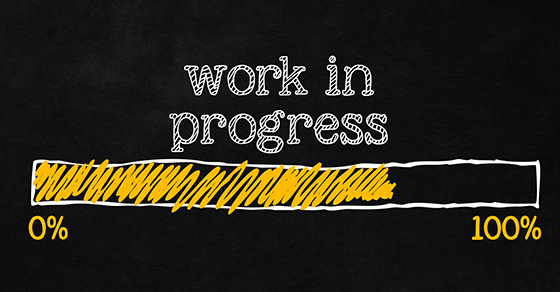